In [2]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf
import pmdarima as pm

os.chdir('../')
from src.features.build_features import (
    daily_return, uniform_clustering, create_shifted_rt, downloading_stocks_data, return_in_period, binary_clustering)
os.chdir('./notebooks')

warnings.filterwarnings("ignore")

# Aquisição dos dados

|Country|Index|Ticker|
|---        |---        |---        |
|Brazil|iBovespa|^BVSP|
|USA|Nasdaq Composite|^IXIC|
|USA|NYSE Composite|^NYA|
|USA|Dow Jones|^DJI|
|Argentina|Merval|M.BA|
|Japan|Nikkei 225|^N225|
|China|Shangai Composite|000001.SS|
|China|Hang Seng|^HSI|
|India|BSE 30 Sensex|^BSESN|
|UK|FTSE 100|^FTSE|
|Sweden|Stockholm General|^OMX|
|Germany|Dax|^GDAXI|
|France|Cac 40|^FCHI|

In [3]:
start_date = "2011-01-01"
end_date = "2021-05-31"

df_ibovespa = yf.download('^BVSP', start=start_date, end=end_date)

# Indices de bolsas:
# ^BVSP
# ^IXIC
# ^NYA
# ^DJI
# M.BA
# ^N225
# 000001.SS
# ^HSI
# ^BSESN
# ^FTSE
# ^OMX
# ^GDAXI
# ^FCHI


[*********************100%***********************]  1 of 1 completed


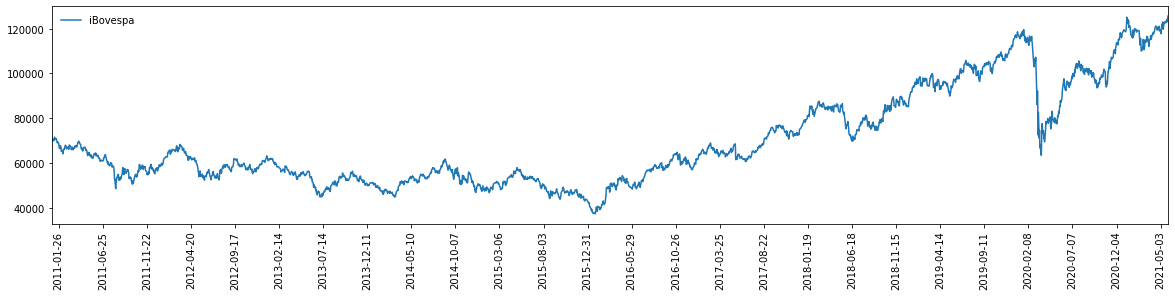

In [4]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_ibovespa['Close'], label="iBovespa")

date_min = df_ibovespa.index.min()
date_max = df_ibovespa.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [9]:
df = df_ibovespa[["Close"]].copy()
df = daily_return(df)
df = binary_clustering(df)
df = create_shifted_rt(df, [1,5,7])
df.dropna(how='any', axis=0, inplace=True)

df.head()

,Close,cluster_Close,Close-1,Close-5,Close-7
Date,,,,,
2011-01-13,-1.281330,0,1.703595,-0.722810,0.507557
2011-01-14,0.309189,1,-1.281330,-0.742345,1.093293
2011-01-17,-0.467683,0,0.309189,0.099869,-0.722810
2011-01-18,0.439487,1,-0.467683,0.421203,-0.742345
2011-01-19,-1.222901,0,0.439487,1.703595,0.099869


In [113]:
ntotal = df.shape[0]
ntest = 20
X_real = df[-ntest:]

resultado = {}


for cont in np.arange(ntest):
    X_train = df[:-ntest+cont]
    X_test = df[-ntest+cont:ntotal-ntest+1+cont]
    
    # X_test = df_ibovespa[-1:]

    # print(f""" 
    # cont : {cont}
    # X_train: {X_train.shape} {X_train.index[-1]}
    # X_test: {X_test.shape} {X_test.index[-1]}\n""")

    X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
    X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
    df_ibovespa["rt"] = (np.log(df_ibovespa["Close"]) - np.log(df_ibovespa["Close"].shift(periods=1)))*100
    X_train = X_train[["Close", "rt"]][1:]
    X_train.head()

    model = pm.auto_arima(X_train['rt'], erro_action='ignore', trace=True, suppress_warnings=True, maxinter=10, stepwise=False, seasonal=False)

    params = model.get_params()
    d = params['order'][1]
    #train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=1, return_conf_int=True)
    resultado[X_test.index[-1]] = test_pred[0]

    print(f"""test_pred, confint : {test_pred} {confint} """)


, Time=0.28 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 7.339 seconds
test_pred, confint : [-0.02573806] [[-3.16641439  3.11493827]] 
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9728.630, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9709.323, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9705.408, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=9707.124, Time=0.19 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=9709.044, Time=0.22 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=9706.762, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9707.450, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9706.606, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9707.229, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=9709.115, Time=0.43 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=9697.012, Time=0.68 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9705.420, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9707.394,

In [116]:
resultado = pd.DataFrame.from_dict(resultado, orient='index', columns=['rt_predict'])

In [121]:
resultado


,rt_predict
2021-05-03,0.062865
2021-05-04,-0.131871
2021-05-05,0.238971
2021-05-06,-0.289030
2021-05-07,0.108957
2021-05-10,-0.131740
2021-05-11,-0.025738
2021-05-12,0.074184
2021-05-13,0.045272
2021-05-14,0.053069


In [119]:
X_real = df_ibovespa[-ntest:]
X_real

,Open,High,Low,Close,Adj Close,Volume,rt
Date,,,,,,,
2021-05-03,118951.0,119904.0,118528.0,119209.0,119209.0,8888300,0.264592
2021-05-04,119209.0,119293.0,117631.0,117712.0,117712.0,8765500,-1.263729
2021-05-05,117725.0,119734.0,117725.0,119564.0,119564.0,9059100,1.561083
2021-05-06,119577.0,119966.0,119071.0,119921.0,119921.0,8779600,0.298140
2021-05-07,119922.0,122038.0,119922.0,122038.0,122038.0,8865100,1.749928
2021-05-10,122038.0,122772.0,121795.0,121909.0,121909.0,8219100,-0.105761
2021-05-11,121904.0,122964.0,120145.0,122964.0,122964.0,7988600,0.861676
2021-05-12,122964.0,122964.0,119458.0,119710.0,119710.0,9405200,-2.681948
2021-05-13,119711.0,121426.0,119711.0,120706.0,120706.0,9356200,0.828569


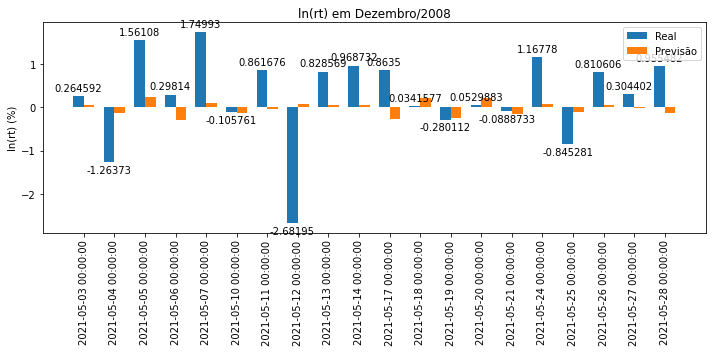

In [126]:
x = np.arange(len(X_real))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, X_real['rt'], width, label='Real')
rects2 = ax.bar(x + width/2, resultado['rt_predict'], width, label='Previsão')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ln(rt) (%)')
ax.set_title('ln(rt) em Dezembro/2008')
ax.set_xticks(x)
ax.set_xticklabels(X_real.index)
plt.xticks(rotation=90)

ax.legend()

ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)


fig.tight_layout()

plt.show()

In [127]:
def rmse(y, t):
    return np.sqrt(np.mean((t - y)**2))

In [128]:
a = rmse(predictions, X_test["rt"])

NameError: name 'predictions' is not defined

In [ ]:
print(f"RSME ARIMA: {round(a, 4)}%")
print("RSME Naive:", rmse(X_train['rt'].iloc[-1], X_test['rt']))